<h1 style="background-color:LimeGreen;"></br><center>Predicting Quality In Vinho Verde <br><br>
   Authors : Shawn Smith, Magdalena Rahn </br></h1>

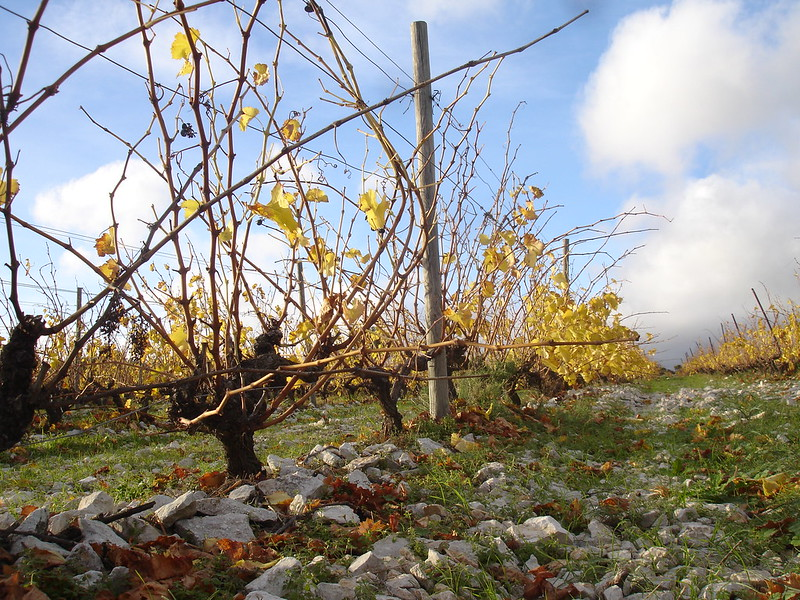

## Project Setting

The purpose of this project is to predict wine quality rating based on exploration and analysis of wines from the Vinho Verde region of Portugal, on data from protected designation of origin wine samples collected from May 2004 to February 2007 and tested at the official Vinho Verde interprofessional certification entity (CVRVV).  

This will be done in Python, using different statistical tests, modeling and graphs.

## Executive Summary

* Acquire & prepare
* Split, scale & explore
* Models — create, compare & decide
* Conclusion and summary

## Data Acquisition

- Data was originally obtained as two .cvs files (red wine, white wine) donated by the University of Minho, Portual, to UCI via Data.World.
- After combining the two .cvs files, the newly acquired dataframe represented 6497 rows and 13 columns.
- Each row represented a different red or white wine.
- Each column represented a different feature of the wine — the fixed acidity (g(tartaric acid)/ℓ), the volatile acidity  (g(_acetic acid_)/ℓ), the citric acid (g/ℓ), the residual sugar (g/ℓ), the chlorides (g(_sodium chloride_)/ℓ), the free sulphur dioxide (mg/ℓ), the total sulphur dioxide (mg/ℓ), the density (g/ℓ), the pH, the sulphates (g(_potassium sulphate_)/ℓ), the alcohol (% vol), the quality, the color.


## Data Preparation

- To prepare the data, it was necessary to drop outliers and any unnecessary columns.
- The single categorical column was encoded, with a dummy variable being created. The dummy variable was then concatenated onto the prepared wine dataframe.
- There were no null values.
- Outliers, being a very small percentage in the overall dataset, were dropped according to the Inter Quartile Range (IQR).
- The chlorides column deemed irrelevant to this project and dropped. 
- Features specifically examined were 
    - (1) the relationship between free and total sulphur dioxide, 
    - (2) the levels of citric acid and residual sugar in the wine, 
    - (3) the density of the wine and 
    - (4) total residual sugar in and the density of the wine.
- These were analysed against the target variable of quality rating of the wine.

## Data Dictionary 

|Feature|              Definition|
| :------|:------|
|**fixed_acidity**|             - the acids naturally occuring in grapes (tartaric, malic, citric) or produced by 
| |yeast during fermentation (succinic)|
|**volatile_acidity**|          - measure of the wines gaseous (volatile) acids, the primary one being acetic 
| |                        acid, which is asociated with vinegar ; overall, pronounced volatile acidity 
| |                            is a negative characteristic|                              
|**citric_acid**|               - often added to post-fermentation wine to balance sugar levels and / or to 
| |                            create a sense of vibrancy |
|**rs**|                        - residual sugar : the amount of sugar remaining in the wine after fermentation|
|**chlorides**|                 - indication of the presence of sodium chloride (salinity) of a wine| 
|**free_s02**|                  - sulphur dioxide is an anti-oxidant (preservative) ; free sulphur dioxide is S02 
| |                                added to the wine that has not reacted with other chemical compounds in the 
| |                                wine ; too much added S02 will produce a sulphury smell in the wine|
|**total_s02**|                 - free and bound S02 ; bound S02 has combined with chemical compounds in the wine |
|**density**|                   - a description of the viscosity, related to alcohol, sugar, glycerol and other 
| |                                dissolved solids in the wine ;
| |                            - related to a wine's mouthfeel ; 
| |                            - specifically, 'the mass per unit volume of wine or must at 20°C. It is 
| |                             expressed in grams per milliliter, and denoted by the symbol ρ' (OIV) ; 
| |                            - alternately, a measurement of the sugar content of the grapes before fermentation
|**pH**|                        - a measure of the relative alkilinity vs the relative acidity of a wine ; usually 
| |                            between 3 and 4 pH ; typically, a wine with a high level of acidity will 
| |                            have a low pH level|
|**alcohol**|                   - percentage alcohol by volume in the finished wine|
|**quality (_target_)**|          - rating / score between 0 and 10, with 10 being the best|

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

# import my functions
import prepare
import env
import prepare_xy_split
import selectKBest_rfe_functions
import functions as f
import wrangle

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


&nbsp;

<h1 style="background-color:LimeGreen;"></br><center>Acquire</br></h1>

In [2]:
# wrangling dataset

wine = wrangle.gimme_wine()

quality column ignored
color column ignored


In [3]:
# checking work

wine.sample(5)

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality,color_white
2566,6.9,0.21,0.24,1.8,0.021,17.0,80.0,0.98992,3.15,0.46,12.3,7,1
3867,7.3,0.25,0.26,7.2,0.048,52.0,207.0,0.99587,3.12,0.37,9.2,5,1
46,6.2,0.45,0.26,4.4,0.063,63.0,206.0,0.99400,3.27,0.52,9.8,4,1
4373,6.1,0.26,0.28,1.7,0.043,24.0,98.0,0.98918,3.14,0.44,12.5,6,1
3249,6.4,0.23,0.35,4.6,0.039,43.0,147.0,0.99216,3.18,0.40,11.0,7,1


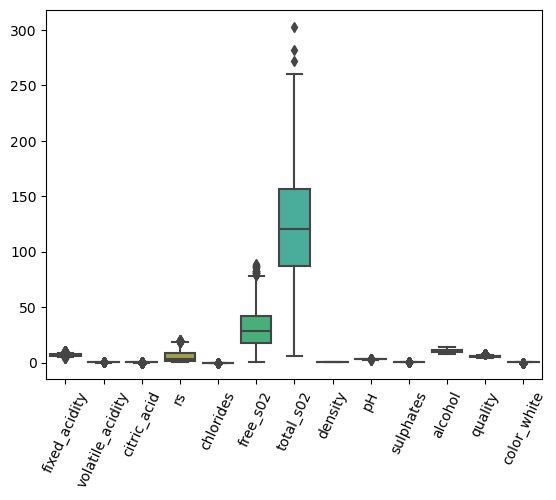

In [4]:
# calling function to look for outliers

f.show_outliers(wine)

> ## ***Takeaway:*** Free and Total S02 have the most significant outliers

> ### ***Splitting the Data*** 

In [5]:
# calling function to split data

train, val, test = prepare.train_val_test(wine, 'quality')
train.shape, val.shape, test.shape

((4017, 13), (1033, 13), (689, 13))

In [6]:
# getting correlation values

wine.corr()

,fixed_acidity,volatile_acidity,citric_acid,rs,chlorides,free_s02,total_s02,density,pH,sulphates,alcohol,quality,color_white
fixed_acidity,1.000000,0.184789,0.224927,-0.071021,0.357396,-0.216615,-0.224479,0.378508,-0.237732,0.182199,-0.120596,-0.097641,-0.393338
volatile_acidity,0.184789,1.000000,-0.438855,-0.188370,0.516304,-0.342204,-0.388926,0.224701,0.256112,0.213767,-0.033140,-0.230810,-0.646675
citric_acid,0.224927,-0.438855,1.000000,0.167138,-0.197575,0.199041,0.269549,0.025369,-0.282480,-0.035505,0.011051,0.090093,0.288709
rs,-0.071021,-0.188370,0.167138,1.000000,-0.108569,0.429072,0.498226,0.611893,-0.282931,-0.165980,-0.397263,-0.044747,0.330302
chlorides,0.357396,0.516304,-0.197575,-0.108569,1.000000,-0.260095,-0.341479,0.517553,0.240164,0.344114,-0.347254,-0.263200,-0.727149
free_s02,-0.216615,-0.342204,0.199041,0.429072,-0.260095,1.000000,0.711680,0.116603,-0.168395,-0.148631,-0.195179,0.067856,0.443179
total_s02,-0.224479,-0.388926,0.269549,0.498226,-0.341479,0.711680,1.000000,0.142080,-0.259219,-0.233621,-0.298677,-0.054430,0.666498
density,0.378508,0.224701,0.025369,0.611893,0.517553,0.116603,0.142080,1.000000,0.050104,0.213899,-0.756523,-0.325071,-0.326935
pH,-0.237732,0.256112,-0.282480,-0.282931,0.240164,-0.168395,-0.259219,0.050104,1.000000,0.306233,0.087432,0.027356,-0.381883
sulphates,0.182199,0.213767,-0.035505,-0.165980,0.344114,-0.148631,-0.233621,0.213899,0.306233,1.000000,0.004344,0.046815,-0.453758


### Scaling the data

In [7]:
# scaling the data

scaler, train_scaled, val_scaled, test_scaled = prepare.scale_splits_rb(train, 
                                                                        val, 
                                                                        test, 
                                                                        return_scaler = True)  

&nbsp;

<h1 style="background-color:LimeGreen;"></br><center>Exploration</br></h1>

### Questions To Explore :
1/ Does density have an effect on the quality of wine ?  
2/ How do sugar and citric acid, when examined together, affect the quality of wine ?   
3/ Is the quality of wine affected by the amount of sulphites ?  
4/ Do sugar and density, examined together, affect a wine's quality ?   

### Question 1 Hypothesis :
* $H_{0}$ : The density of the wine has no relationship to its quality.
* $H_{a}$ : The density of the wine has a relationship to its quality.

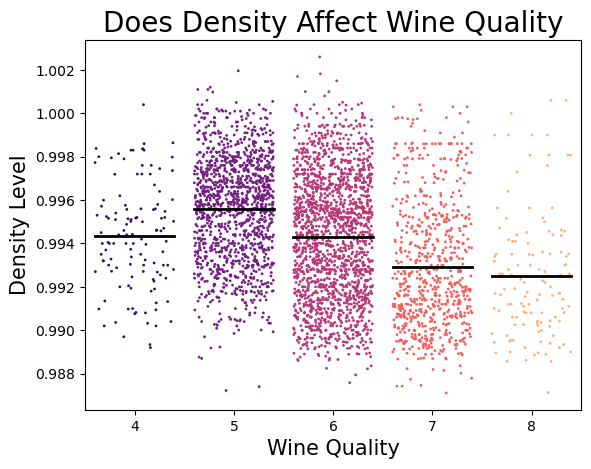

In [8]:
# calling function to show density v. quality

f.density_quality(train)

> ## ***Takeaway :*** The lower the density, the better the wine

In [9]:
# calling function to run T-test

results1 = f.t_test(train.quality, train.density)

T-Score is:  362.8630437322157

P-Value is:  0.0

We reject the null hypothesis as there is a
significant relationship between density and quality of wine.


># Clustering 

### Question 2 Hypothesis :
* $H_{0}$ : The levels of sugar and citric acid in the wine are independent of its quality.
* $H_{a}$ : The levels of sugar and citric acid in the wine have a relationship to its quality.

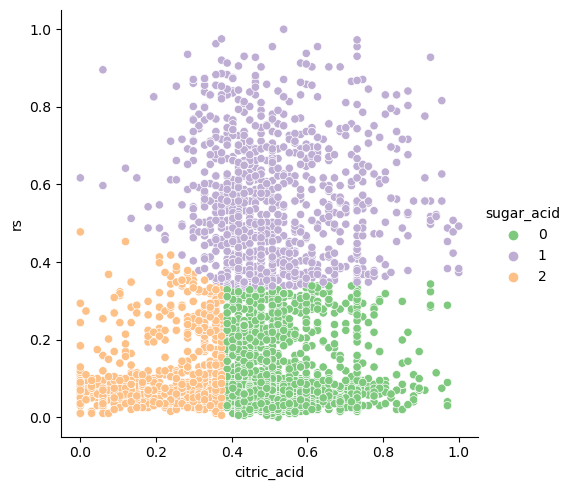

In [10]:
# calling function to cluster residual sugar + citric acid

f.cluster_sugar_acid(train_scaled)

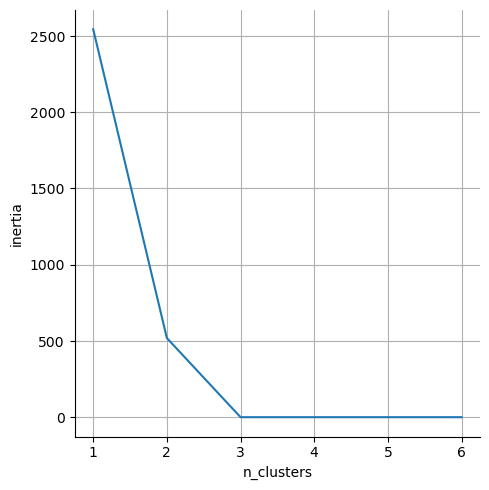

In [11]:
# inertia elbow function

f.elbow(train_scaled, 'sugar_acid')

> ## ***Takeaway :*** 3 Clusters —  
>### *High Acid/Low Sugar - Medium Acid/High Sugar - Low Acid/Low Sugar

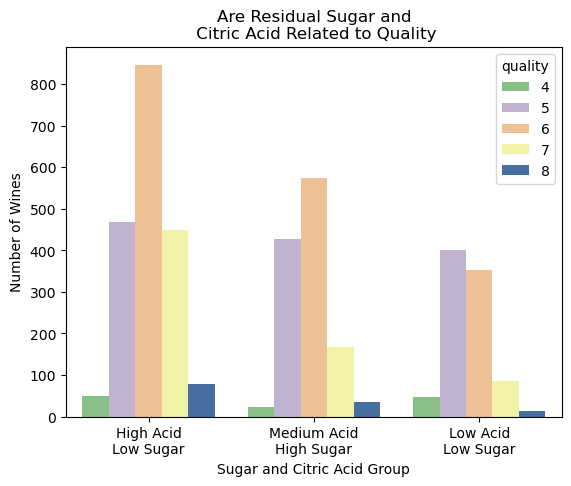

In [12]:
# plotting sugar + citric acid clusters against quality

f.sugar_acid_compare(train_scaled)

>## ***Takeaway :*** High acid and low sugar, taken together, has the largest volume of high-quality wines (quality ratings of 7 or 8)

In [13]:
# calling function to run Chi^2 test

sugar_acid_result = f.chi_sq(train_scaled.quality, train_scaled.sugar_acid)

chi^2  = 203.9950

p-value = 0.0000

We reject the null hypothesis as there is a dependence 
between the selected feature and quality of wine.


### Question 3 Hypothesis :
* $H_{0}$ : The overall quality of the wine has no relationship to the amount of sulphites present.
* $H_{a}$ : The overall quality of the wine has a relationship to the amount of sulphites present.

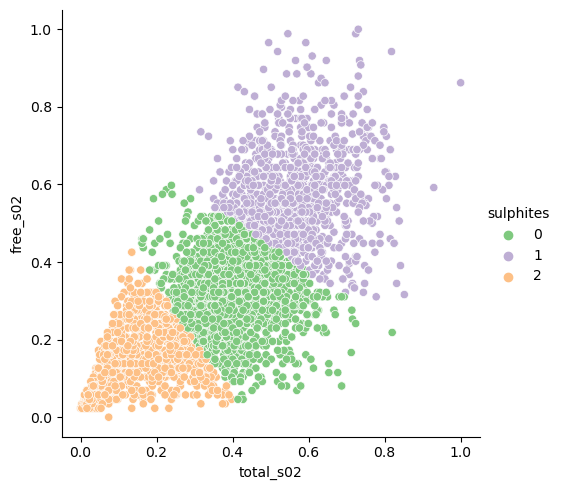

In [14]:
# calling function to cluster free and total S02

f.cluster_sulphites(train_scaled)

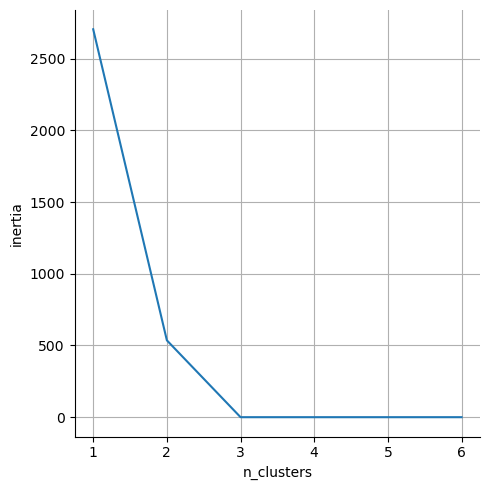

In [15]:
# inertia elbow function

f.elbow(train_scaled, 'sulphites')

> ## ***Takeaway :*** 3 Clusters — 
>### * Low Free and Total S02 - High Free and Total S02 - Low Free and High Total S02

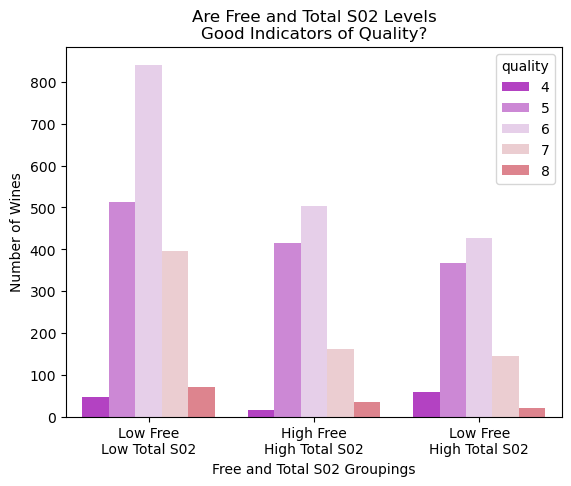

In [16]:
# plotting Free and Total S02 feature against quality

f.sulphites_compare(train_scaled)

> ## ***Takeaway :*** Low sulphite levels resulted in having the largest volume of high-quality wines (quality ratings of 7 or 8)

In [17]:
# calling function to run Chi^2 test

sulphites_result = f.chi_sq(train_scaled.quality, train_scaled.sulphites)

chi^2  = 97.6935

p-value = 0.0000

We reject the null hypothesis as there is a dependence 
between the selected feature and quality of wine.


### Question 4 Hypothesis :
* $H_{0}$ : The total residual sugar in and the density of the wine have no relationship to its quality.
* $H_{a}$ : The total residual sugar in and the density of the wine have a relationship to its quality.

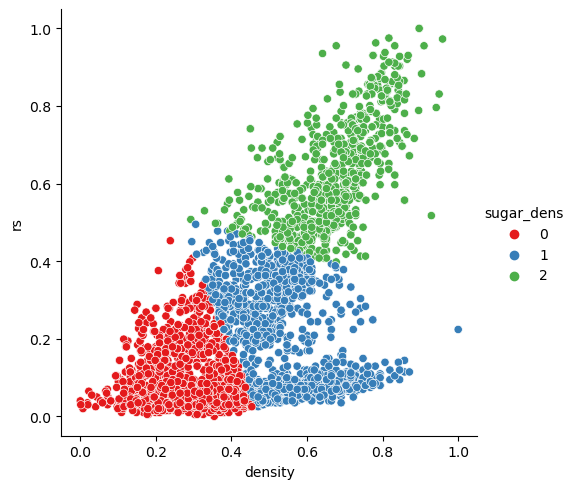

In [18]:
# calling function to cluster residual sugar and density
f.cluster_sug_dens(train_scaled)

> ## ***Takeaway :*** 3 Clusters - 
>### *Low Density/Low Sugar - Med - High Density/Low Sugar - High Density/High Sugar

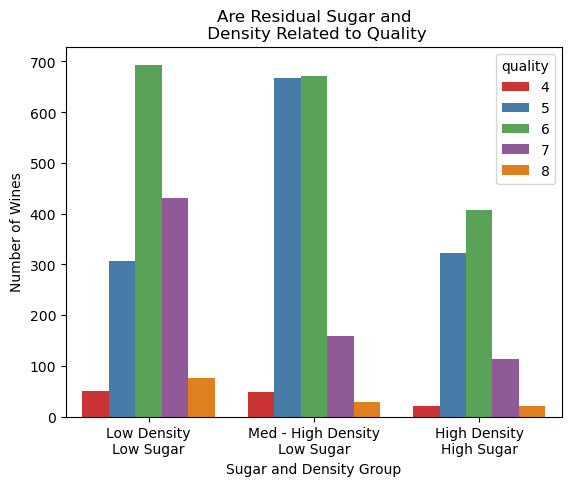

In [19]:
# plotting residual sugar and density feature against quality

f.sugar_dens_compare(train_scaled)

> ## ***Takeaway :*** High density and low sugar, explored together, has the largest volume of high-quality wines (quality ratings of 7 or 8) 
> ## Contradicts earlier finding of low density having better quality, when density is combined with residual sugar

In [20]:
# calling function to run Chi^2 test

sugar_density_result = f.chi_sq(train_scaled.quality, train_scaled.sugar_dens)

chi^2  = 312.2628

p-value = 0.0000

We reject the null hypothesis as there is a dependence 
between the selected feature and quality of wine.


## Exploration Summary
#### * While we did find a relationship between the features we explored with quality as our target, we observed that the strongest relationships were between *density* by itself and *sugar and citric acid* combined.
#### * We will move forward into modelling with these features

&nbsp;

<h1 style="background-color:LimeGreen;"></br><center>Modelling</br></h1>

# Feature Selection Using SelectKBest and Recursive Feature Engineering 
## SelectKBest on features featured in the hypotheses

In [21]:
# running selectKBest on hypotheses features

selectKBest_rfe_functions.select_best(train_scaled, ['total_s02', 'rs', 'citric_acid', 
                                              'density', 'free_s02', 
                                              'sugar_acid', 'sulphates'], 
                                              'quality', 2)

Index(['density', 'sugar_acid'], dtype='object')

**TAKEAWAY : According to the SelectKBest feature selection method, 'density' and 'sugar_acid' would be the highest positive correlation to wine quality rating.**

&nbsp;

## RFE on features in the hypotheses

In [22]:
# RFE on training dataset

selectKBest_rfe_functions.rfe_function(train, 3, 'quality', dummy_columns = []).head(5).T

,4,7,9,1,10
ranking,1,1,1,2,3
feature,chlorides,density,sulphates,volatile_acidity,alcohol


The RFE model indicates that chlorides, density and sulphates have the highest influence in predicting a given wine's quality rating.

**TAKEAWAY :** 

**SelectKBest indicates that the features 'citric_acid' and 'density' have the highest influence on the quality score of a given wine.  However, recursive feature elimination (RFE) indicates that the highest influencers on a given wine's quality score are 'chlorides', 'density' and 'sulphates'.**  

**From this, we can determine that further exploration, statistical testing and modelling needs to be done in order to truly determine quality influencers.**

&nbsp;

# Regression

## Question 2, part I : Do the levels of citric acid and residual sugar in the wine have a relationship to its quality ?

### Object of least squares (OLS) on Linear Regression

In [23]:
# ols function on train + residual sugar & citric acid cluster

f.quality_ols(train_scaled, 'sugar_acid')

The RMSE on the baseline against wine quality is 0.8488.
The RMSE for the OLS Linear Regression model was 0.8304.


**TAKEAWAY, OLS FOR SUGAR & CITRIC ACID CLUSTER :**
**The RMSE for the OLS Linear Regression model on sugar & citric acid was 0.8304. This was slightly lower, and thus, more accurate, than the RMSE on the baseline (0.8488). The OLS model was a 0.0184 improvement on the baseline.**

## Question 2, part II : Do the levels of citric acid and residual sugar in the wine have a relationship to its quality ?

### Tweedie Regressor on Linear Regression

In [24]:
# dividing into Xs and ys 

X_train, y_train, X_val, y_val, X_test, y_test = f.tts_xy(train_scaled,
                                                          val_scaled, test_scaled, 'quality')

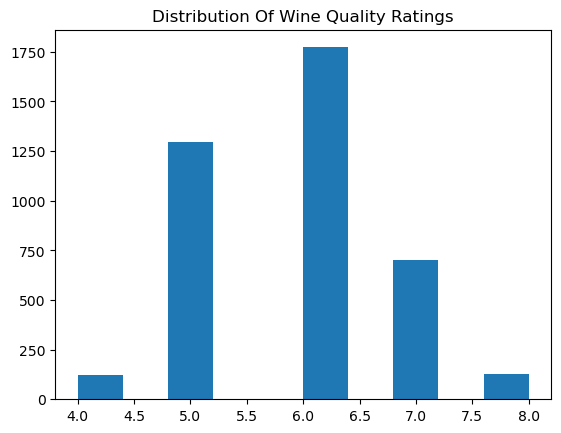

In [25]:
# plotting to look at the data

plt.hist(y_train)
plt.title('Distribution Of Wine Quality Ratings')
plt.show()

This is a normal distribution.

In [26]:
# RMSE for 'sugar_acid' on training dataset

f.tweedie_sugar_acid(train_scaled, X_train, y_train)

The RMSE for the Tweedie Regressor model was 0.8373.
The RMSE on the baseline of sugar & citric acid against wine quality is 0.8488.


**TAKEAWAY, TWEEDIE REGRESSOR FOR SUGAR & CITRIC ACID CLUSTER : The RMSE for the Tweedie Regressor Linear Regression model on the training dataset for the sugar & citric acid cluster was 0.8373. This was a 0.0115 improvement on the RMSE of the baseline for this cluster.**

### OVERALL REGRESSION TAKEAWAYS FOR SUGAR & CITRIC ACID CLUSTER ON TRAIN :

**The RMSE on the baseline for citric acid & sugar against wine quality was 0.8488. The RMSE for the OLS Linear Regression model was 0.8304. The RMSE for the Tweedie Regressor model was 0.8373. Both the OLS and the Tweedie Regressor models were more accurate in their predictions of wine quality rating than the baseline.**  

**Of the two models, the OLS model was the more accurate, by 0.0069, than the Tweedie Regressor model. The OLS model was 0.0184 more accurate than the baseline. Given the closeness of the two models, both will be trialled against the validate dataset.**

&nbsp;

## COMPARING OLS & TWEEDIE REGRESSOR ON VALIDATE, Residual Sugar & Citric Acid

### OLS on validate for 'sugar_acid'

In [27]:
# adding necessary columns

f.sugar_acid_col(val_scaled).sample(3)

# assuring necessary columns on DFs for val & test
val_scaled = f.sugar_acid_col(val_scaled)
X_val = f.sugar_acid_col(X_val)
test_scaled = f.sugar_acid_col(test_scaled)
X_test = f.sugar_acid_col(X_test)

In [28]:
# ols funtion on validate + residual sugar & citric acid cluster

f.quality_ols(val_scaled, 'sugar_acid')

The RMSE on the baseline against wine quality is 0.8379.
The RMSE for the OLS Linear Regression model was 0.81.


### Tweedie on validate for 'sugar_acid'

In [29]:
# finding the RMSE using Tweedie Regressor on the validate dataset

f.tweedie_sugar_acid(val_scaled, X_val, y_val)

The RMSE for the Tweedie Regressor model was 0.8208.
The RMSE on the baseline of sugar & citric acid against wine quality is 0.8379.


### OVERALL REGRESSION TAKEAWAYS FOR SUGAR & CITRIC ACID CLUSTER ON VALIDATE :

**Using the validate dataset, the RMSE on the baseline for citric acid & sugar against wine quality was 0.8379. The RMSE for the OLS Linear Regression model was 0.81. The RMSE for the Tweedie Regressor model was 0.8208. Both the OLS and the Tweedie Regressor models were more accurate in their predictions of wine quality rating than the baseline.**

**The OLS model was 0.0108 more accurate than the Tweedie Regressor model using the validate dataset, and 0.0279 more accurate than the baseline. This being, the test dataset will now be used against the OLS model.**

## OLS MODEL USING TEST, Sugar & Citric Acid

In [30]:
# ols funtion on test + residual sugar & citric acid cluster

f.quality_ols(test_scaled, 'sugar_acid')

The RMSE on the baseline against wine quality is 0.8673.
The RMSE for the OLS Linear Regression model was 0.8589.


**TAKEAWAY : The OLS model on the test dataset for the residual sugar & citric acid cluster performs better than the train and validate datasets, without veering towards overfitting. The RMSE of 0.8589 was 0.0084 lower than the baseline (baseline RSME 0.8673).**

### OVERALL REGRESSION TAKEAWAYS FOR SUGAR & CITRIC ACID CLUSTER ON TEST :

**Using the test dataset, the RMSE on the baseline for citric acid & sugar against wine quality was 0.8673. The RMSE for the OLS Linear Regression model was 0.8589. The OLS model was more accurate (by 0.0084) in its predictions of wine quality rating than the baseline.**

**The model, throughout train, validate and test, has been relatively consistent in its predictions and appears to have avoided overfitting.**

&nbsp;

## Regression

## Question 3, part I : Does the density of a wine have a relationship to its quality ?  
### Object of least squares (OLS) on Linear Regression

In [31]:
# ols funtion on train + density

f.quality_ols(train_scaled, 'density')

The RMSE on the baseline against wine quality is 0.8488.
The RMSE for the OLS Linear Regression model was 0.8064.


**TAKEAWAY, DENSITY AGAINST QUALITY ON OLS :**  

**The RMSE on the baseline of density against wine quality is 0.8488. The RMSE for the OLS Linear Regression model was 0.8064. The difference between the actual and the predicted quality score was 0.8064 for the OLS Linear Regression model. This means that the OLS model is 0.0423 more accurate than the baseline in regards to density and quality on the training dataset.**

## Question 3, part II : Does the density of a wine have a relationship to its quality ?  
### General Linear Regression, Tweedie Regressor

In [32]:
# tweedie regression function on train + density

f.tweedie_density(train_scaled, X_train, y_train)

The RMSE for the Tweedie Regressor model was 0.8461.
The RMSE on the baseline of density against wine quality is 0.8488.


**Takeaway : The Tweedie Regressor model on density, with an RMSE of 0.8461, using the training dataset is 0.0027 more accurate than the baseline (RMSE 0.8488).**

### TRAIN DATASET REGRESSION MODELLING TAKEAWAYS, DENSITY :

**The Linear Regression OLS model, with an RMSE of 0.8064, was 0.0424 more accuate than the baseline (0.8488) on the train dataset. The Tweedie Regressor model on the train dataset, with an RMSE result of 0.8461, was 0.0397 less accurate than Linear Regression OLS. Both models were more accurate than the baseline. The OLS model is preferred on the training dataset when examining density due to the lower RMSE of the OLS model.**

&nbsp;

## Running OLS & Tweedie Regressor On Validate, Density

In [33]:
# ols funtion on validate + density

f.quality_ols(val_scaled, 'density')

The RMSE on the baseline against wine quality is 0.8379.
The RMSE for the OLS Linear Regression model was 0.7873.


**TAKEAWAY :**  

**The RMSE of density against wine quality baseline was 0.8379 on the validate dataset. The RMSE for the OLS Linear Regression model was 0.7873 on the validate dataset.**  

**The difference on the validation dataset between the actual and the predicted quality score on the validation dataset was 0.0506 for the OLS Linear Regression model. This means that the OLS model on the validate dataset was 0.0506 more accurate than the baseline.**

## Tweedie Regressor On The Validate Dataset

In [34]:
# Tweedie Regressor function on validate + density

f.tweedie_density(val_scaled, X_val, y_val)

The RMSE for the Tweedie Regressor model was 0.8348.
The RMSE on the baseline of density against wine quality is 0.8379.



**TAKEAWAY : The RMSE for the Tweedie Regressor model was 0.8348 on the validate dataset in regards to the density of the wine having a relationship to its quality. This is 0.003 more accurate than the baseline RMSE for density on quality.**
    


### VALIDATION DATASET REGRESSION MODELING TAKEAWAYS, DENSITY :

**The OLS Linear Regression model, with an RMSE of 0.7873, was 0.0615 more accuate than the baseline (RMSE 0.8379) using the validate dataset for density on quality. The RMSE of the Tweedie Regressor model for the validate dataset (0.8348) was also more accurate than the baseline RMSE, but it was less accurate than the OLS model (RMSE 0.7873) for density.**  

**Going forward, the OLS model will be run against the test dataset.**


## OLS MODEL USING TEST, Density

In [35]:
# ols funtion on test + residual sugar & citric acid cluster

f.quality_ols(test_scaled, 'density')

The RMSE on the baseline against wine quality is 0.8673.
The RMSE for the OLS Linear Regression model was 0.8041.


**TAKEAWAY : The OLS model on the test dataset for the density performs better than the train and validate datasets, without veering towards overfitting. The RMSE of 0.8041 was 0.0632 lower than the baseline (baseline RSME 0.8673).**

### OVERALL REGRESSION TAKEAWAYS FOR DENSITY ON TEST :

**Using the test dataset, the RMSE on the baseline for density against wine quality was 0.8673. The RMSE for the OLS Linear Regression model was 0.8041. The OLS model was more accurate (by 0.0632) in its predictions of wine quality rating than the baseline.**

**The OLS model, throughout train, validate and test, has been relatively consistent in its predictions and appears to have avoided overfitting.**

&nbsp;

## Classification

### Question 2 : Do the levels of citric acid and residual sugar in a wine have a relationship to its quality ?

## Part I, Using Decision Tree

In [38]:
# determining the most common quality score

quality_baseline = train.quality.value_counts()
quality_baseline

6    1773
5    1296
7     703
8     125
4     120
Name: quality, dtype: int64

**A quality score of 6 is the most common, with 1778 wines.**

In [39]:
# running the decision tree function

f.decision_tree(train_scaled, X_train, y_train)

The baseline of about 0.4414 indicates the likelihood that a wine will score a 6 for its quality rating.
Decision Tree Accuracy, max depth of 11 : 0.815


In [40]:
# running the decision tree function

f.decision_tree(train_scaled, X_val, y_val)

The baseline of about 0.4414 indicates the likelihood that a wine will score a 6 for its quality rating.
Decision Tree Accuracy, max depth of 11 : 0.8964


In [41]:
# running the decision tree function

f.decision_tree(train_scaled, X_test, y_test)

The baseline of about 0.4414 indicates the likelihood that a wine will score a 6 for its quality rating.
Decision Tree Accuracy, max depth of 11 : 0.9361


**TAKEAWAY :**  

*** The accuracy of the Decision Tree Classifier with 11 branches is about 81.5pc on train, about 89.64pc on validate, and about 93.61pc on test.**   

*** The baseline of about 44.14pc indicated the likelihood that a wine will score a 6 for its quality rating. While it is clear that the Decision Tree model is much more accurate, by 37.36pc, on the train dataset than the baseline prediction, it is prone to overfitting.**

&nbsp;

## Part II, Using Random Forest

In [42]:
# random forest function

f.random_forest(X_train, y_train)

Random Forest Accuracy, max depth of 11 : 0.8392


In [43]:
# random forest function

f.random_forest(X_val, y_val)

Random Forest Accuracy, max depth of 11 : 0.9206


### CLASSIFICATION TAKEAWAYS :

**The Random Forest model with 11 branches had an accuracy rate of 83.92pc. The accuracy of the Decision Tree  with 11 branches was about 81.5pc on train, about 92.06pc on validate and about 94.63pc on test.**

**Both models are more accurate than the baseline prediction, with the Random Forest model at 11 branches on the train dataset, at an accuracy of 83.5pc, being 39.78pc more accurate than the baseline prediction of 44.14pc, but, like the Decision Tree Classifier, the Random Forest model is also prone to overfitting.**

&nbsp;

<h1 style="background-color:LimeGreen;"></br><center>Conclusions</br></h1>


>### Modeling
* When performing _Regression_ (object of least squares, Tweedie regressor) on two key groups of data (the relationship of residual sugar + citric acid to quality, the relationship of a wine's density to its quality), the OLS model consistently outperformed the Tweedie Regressor model throughout the train and validate datasets. 


* For this reason, the OLS model was selected as the better of the two for the test dataset.
    - On the test dataset, the OLS RMSE for residual sugar + citric acid was 0.8589, or 0.0084 better in its predictions of wine quality rating than the baseline.
    - On the test dataset for density, the OLS RMSE was 0.8673, or 0.0632 better in its predictions when compared to the baseline.  
    
    
* In regards to _Classification_ models, both the Decision Tree Classifier and the Random Forest were used, both at a depth of 11 branches. 
    - While the resulting accuracy for both was promising on the train dataset, by the time the model was run on validate and test, it was clear that both models were highly prone to overfitting. 
    - For this reason, it is suggested to prefer regression modelling on this wine quality data.


>### Recommendations
* When determining wine quality, individual features can help in selecting the best drivers of quality. 

* Combining features can expand the ability to deliver the best-quality wines. 

* Use regression models to avoid overfitting.  

* Continue to prefer winemaking techniques that use a lower overall level of sulphites, as this was shown to lead to higher quality ratings.

>### Next Steps
* Find the closest individually related feature to quality and combine that with every other feature and bounce it off of the quality to pinpoint which feature could indicate what makes the best wines. 

* Explore the influence of other phytochemical additives to wine in relationship to its quality, specifically sulphates (potassium sulphate).